time_col_use: center_idx
label_col_use: win_label
n_features: 67
PCA components: 25
explained variance ratio (sum): 0.9542604763892745
T2_limit: 113.50376340099066 Q_limit: 5.809027106760005
saved: mspc_train.csv mspc_test.csv


,center_idx,win_label,win_i,start_idx,end_idx,T2,Q,T2_limit,Q_limit,is_T2_alarm,is_Q_alarm,is_alarm
0,128.0,0.0,0.0,0.0,255.0,38.008986,2.931048,113.503763,5.809027,0,0,0
1,384.0,0.0,1.0,256.0,511.0,15.564390,3.580459,113.503763,5.809027,0,0,0
2,640.0,0.0,2.0,512.0,767.0,39.694257,3.805490,113.503763,5.809027,0,0,0
3,896.0,0.0,3.0,768.0,1023.0,34.354307,3.150276,113.503763,5.809027,0,0,0
4,1152.0,0.0,4.0,1024.0,1279.0,41.772329,3.731247,113.503763,5.809027,0,0,0


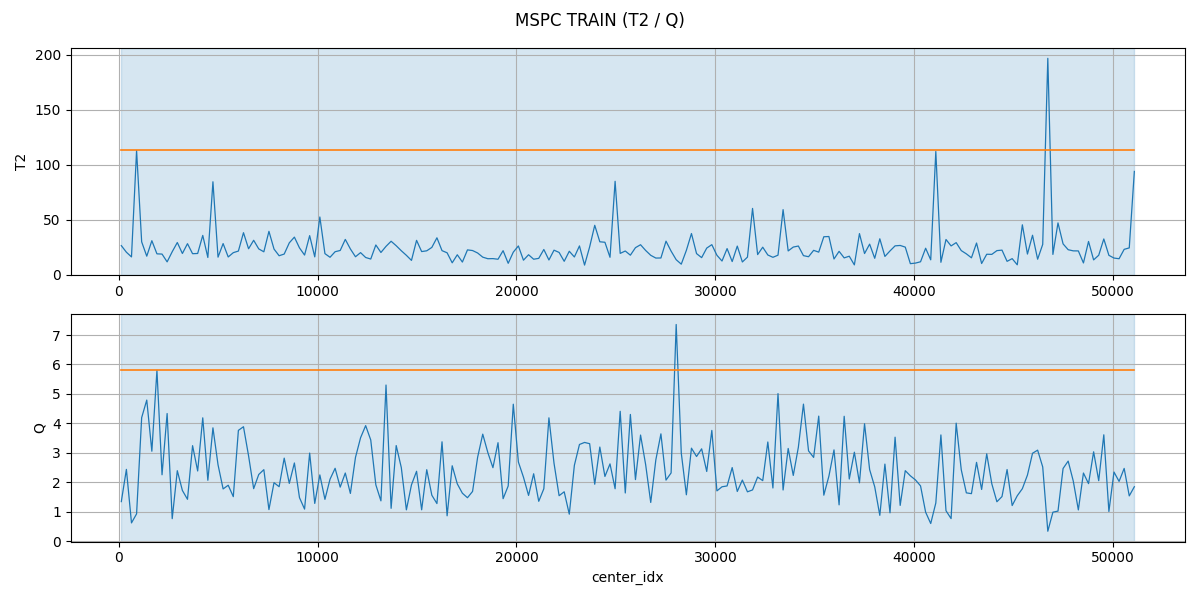

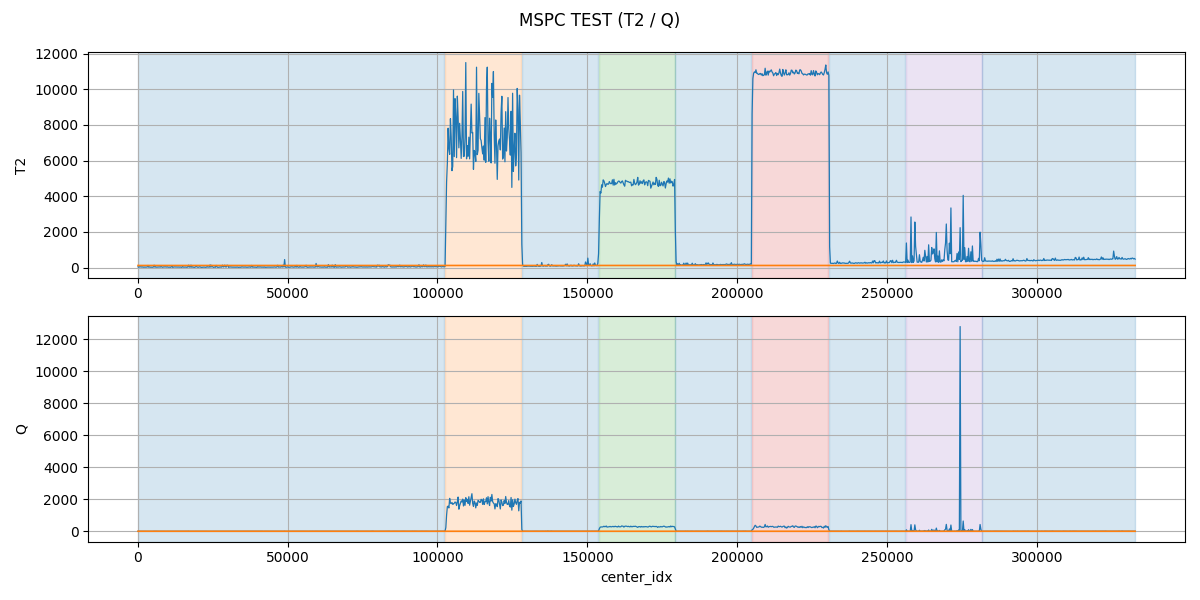

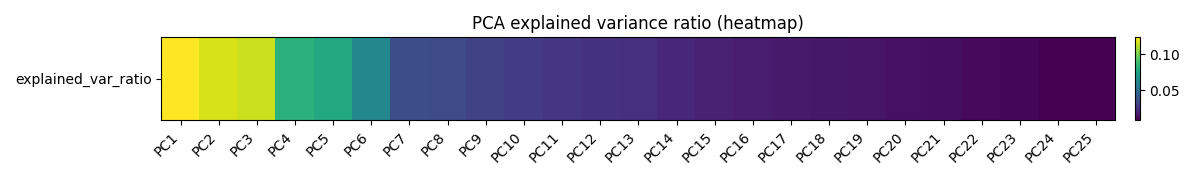

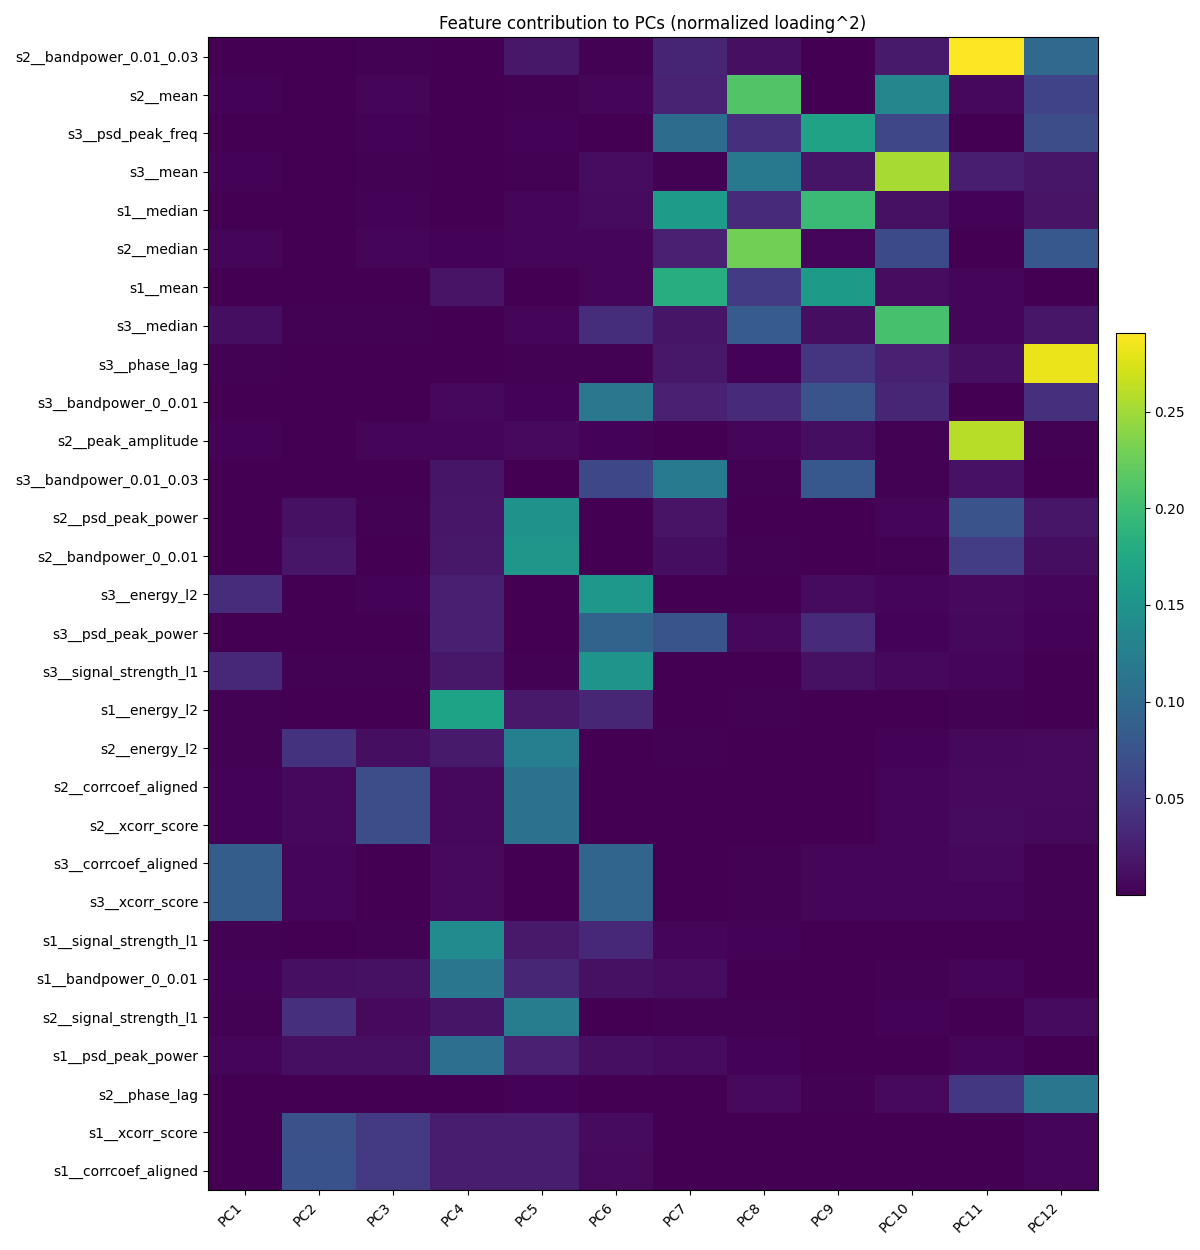

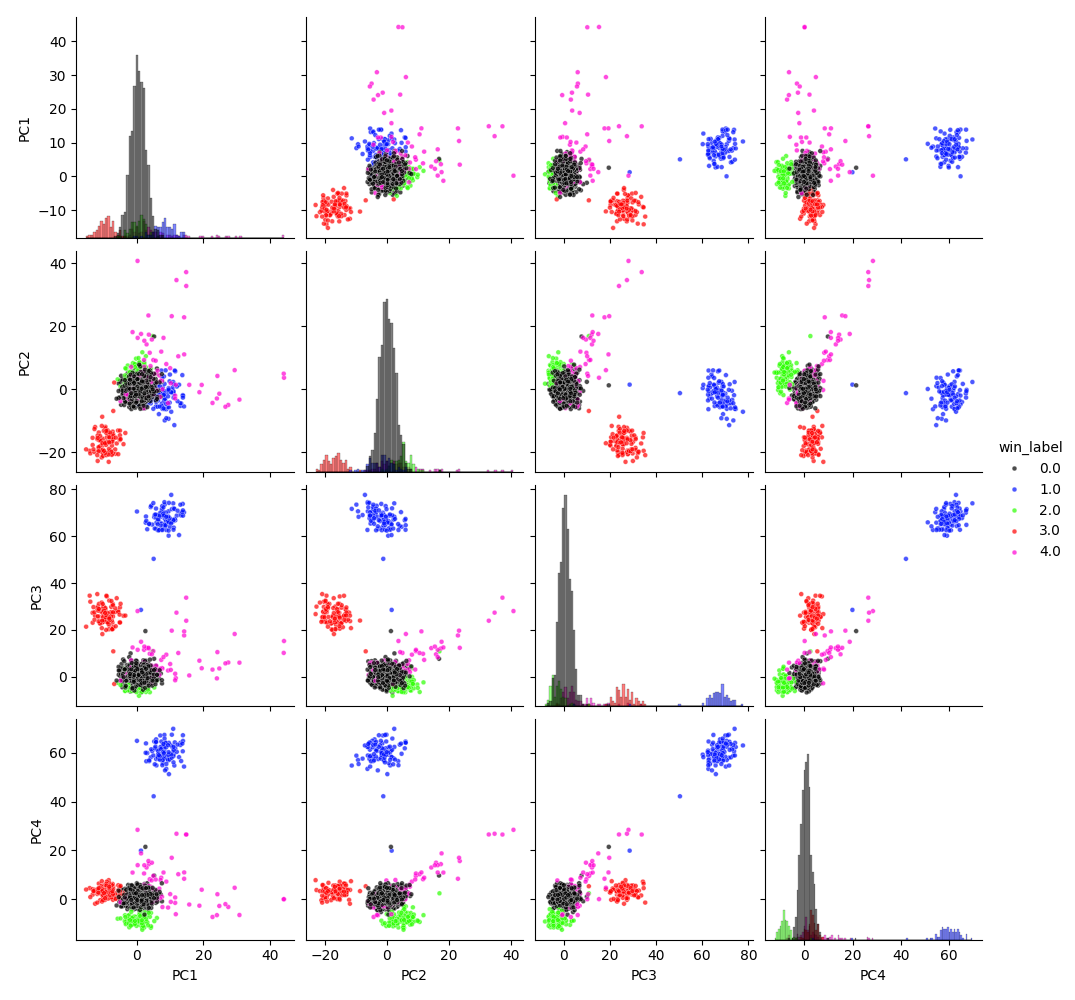

In [11]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================================================
# 0) 設定（ここだけ触れば流れが追える）
#    - 特徴量CSVを読み込む（既に作ってある前提）
#    - 時刻列 / ラベル列は「無ければ自動で index 扱い / None 扱い」
# ============================================================
FEAT_TR_CSV = r"features_train.csv"
FEAT_TE_CSV = r"features_test.csv"

# 特徴量CSVに「時刻（横軸）」として使いたい列名（無ければ自動で index）
TIME_COL_IN_FEAT  = "center_idx"

# 特徴量CSVにラベル列がある場合（背景塗り・色分けに使う。無ければ None 扱い）
LABEL_COL_IN_FEAT = "win_label"

# 学習に使う行を「ラベル=0だけ」に絞りたい場合（正常だけで学習したいとき）
FILTER_TRAIN_LABEL0 = False
TRAIN_NORMAL_LABEL  = 0

# PCA 次元数の決め方
USE_VAR_RATIO = True     # True: 寄与率（累積）で決める / False: 固定本数
VAR_RATIO = 0.95         # 例：累積 95% まで主成分を使う
N_COMPONENTS_FIXED = 8   # USE_VAR_RATIO=False のときだけ使う

# 管理限界（しきい値）
ALPHA = 0.995
USE_EMPIRICAL_LIMIT = True   # True: 学習スコアの分位点（実務で安定） / False: 理論式

# 出力
MSPC_TR_CSV = "mspc_train.csv"
MSPC_TE_CSV = "mspc_test.csv"


# ============================================================
# 1) CSV読み込み（落ちにくく）
# ============================================================
def read_csv_robust(path: str) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8-sig", "utf-8", "cp932", "shift_jis"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    try:
        return pd.read_csv(path, encoding_errors="replace")
    except Exception as e:
        raise RuntimeError(f"CSVが読み込めませんでした: {path}\n最後のエラー: {last_err}\n最終試行エラー: {e}")


# ============================================================
# 2) 読み込んだCSVから「特徴量列」を自動抽出
#    - 数値列だけ候補
#    - 時刻/ラベル/メタっぽい列は除外
# ============================================================
def pick_feature_cols(df: pd.DataFrame, time_col=None, label_col=None):
    meta_like = set()

    if time_col is not None and time_col in df.columns:
        meta_like.add(time_col)
    if label_col is not None and label_col in df.columns:
        meta_like.add(label_col)

    # windowize由来で混ざりやすい列（あれば除外）
    for c in ["win_i","start_idx","end_idx","center_idx","t_center_idx",
              "segment","cycle_id","sample_in_cycle","win_label"]:
        if c in df.columns:
            meta_like.add(c)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in num_cols if c not in meta_like]
    return feat_cols


# ============================================================
# 3) Q（SPE）管理限界：Jackson & Mudholkar (1979)
# ============================================================
def q_limit_jackson_mudholkar(resid_eigs: np.ndarray, alpha: float):
    lam = np.asarray(resid_eigs, dtype=float)
    lam = lam[np.isfinite(lam) & (lam > 0)]
    if lam.size == 0:
        return 0.0

    th1 = np.sum(lam)
    th2 = np.sum(lam**2)
    th3 = np.sum(lam**3)

    if th2 <= 0 or th1 <= 0:
        return 0.0

    h0 = 1.0 - (2.0 * th1 * th3) / (3.0 * (th2**2) + 1e-12)
    h0 = np.clip(h0, 1e-6, 1e6)

    z = float(stats.norm.ppf(alpha))
    term = 1.0 + (z * np.sqrt(2.0 * th2) * h0) / (th1 + 1e-12) + (th2 * h0 * (h0 - 1.0)) / ((th1**2) + 1e-12)
    term = max(term, 1e-12)
    return float(th1 * (term ** (1.0 / h0)))


# ============================================================
# 4) T2 管理限界（理論）：F分布
# ============================================================
def t2_limit_fdist(N: int, a: int, alpha: float):
    if a <= 0 or N <= a + 1:
        return np.inf
    F = float(stats.f.ppf(alpha, a, N - a))
    return float(a * (N - 1) / (N - a) * F)


# ============================================================
# 5) MSPC 学習：標準化 + PCA +（学習データから）しきい値決定
#    ここで返す model を使って、train/test を同じ条件で採点する
# ============================================================
def fit_mspc_pca(df_tr: pd.DataFrame, feat_cols: list[str],
                 alpha=0.995,
                 use_var_ratio=True, var_ratio=0.95, n_components_fixed=8,
                 use_empirical_limit=True):

    # --- 特徴量行列（数値化）
    X = df_tr[feat_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)

    # --- 欠損/inf を「学習データ列平均」で埋める（この平均は test にも使う）
    col_mean = np.nanmean(X, axis=0)
    bad = np.where(~np.isfinite(X))
    if bad[0].size:
        X[bad] = col_mean[bad[1]]

    # --- 標準化（列ごとに平均0・分散1）
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # --- 主成分数 a を決める
    if use_var_ratio:
        pca0 = PCA(svd_solver="full")
        pca0.fit(Xs)
        csum = np.cumsum(pca0.explained_variance_ratio_)
        a = int(np.searchsorted(csum, var_ratio) + 1)
        a = max(1, min(a, Xs.shape[1]))
        pca = PCA(n_components=a, svd_solver="full")
    else:
        a = int(n_components_fixed)
        a = max(1, min(a, Xs.shape[1]))
        pca = PCA(n_components=a, svd_solver="full")

    pca.fit(Xs)

    # --- 学習データの T2 / Q を計算
    T = pca.transform(Xs)            # 主成分空間の座標
    Xhat = pca.inverse_transform(T)  # PCAで復元した値
    E = Xs - Xhat                    # 復元誤差（取りこぼし）

    lam = np.maximum(pca.explained_variance_, 1e-12)
    T2 = np.sum((T**2) / lam[None, :], axis=1)  # 主成分側の異常度
    Q  = np.sum(E**2, axis=1)                   # 復元誤差側の異常度

    # --- しきい値
    N = Xs.shape[0]
    if use_empirical_limit:
        # 学習データの「上位 alpha だけが超える値」をしきい値にする（現場で安定しやすい）
        t2_lim = float(np.quantile(T2, alpha))
        q_lim  = float(np.quantile(Q,  alpha))
    else:
        # 理論式（前提が強いので、実データだと合わないことがある）
        t2_lim = t2_limit_fdist(N=N, a=pca.n_components_, alpha=alpha)
        pca_full = PCA(svd_solver="full")
        pca_full.fit(Xs)
        resid_eigs = pca_full.explained_variance_[pca.n_components_:]
        q_lim = q_limit_jackson_mudholkar(resid_eigs, alpha=alpha)

    return {
        "feat_cols": feat_cols,
        "col_mean": col_mean,
        "scaler": scaler,
        "pca": pca,
        "alpha": float(alpha),
        "t2_limit": float(t2_lim),
        "q_limit": float(q_lim),
    }


# ============================================================
# 6) 採点：T2/Q とアラーム（しきい値超え）を返す
#    ついでに「PCスコア（T）」も返して、後で散布図に使えるようにする
# ============================================================
def mspc_score(df: pd.DataFrame, model: dict):
    feat_cols = model["feat_cols"]
    col_mean  = model["col_mean"]
    scaler    = model["scaler"]
    pca       = model["pca"]

    X = df[feat_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
    bad = np.where(~np.isfinite(X))
    if bad[0].size:
        X[bad] = col_mean[bad[1]]

    Xs = scaler.transform(X)

    T = pca.transform(Xs)
    Xhat = pca.inverse_transform(T)
    E = Xs - Xhat

    lam = np.maximum(pca.explained_variance_, 1e-12)
    T2 = np.sum((T**2) / lam[None, :], axis=1)
    Q  = np.sum(E**2, axis=1)

    t2_lim = model["t2_limit"]
    q_lim  = model["q_limit"]

    df_score = pd.DataFrame({
        "T2": T2,
        "Q": Q,
        "T2_limit": t2_lim,
        "Q_limit": q_lim,
        "is_T2_alarm": (T2 > t2_lim).astype(int),
        "is_Q_alarm":  (Q  > q_lim).astype(int),
    })
    df_score["is_alarm"] = ((df_score["is_T2_alarm"] == 1) | (df_score["is_Q_alarm"] == 1)).astype(int)

    return df_score, T


# ============================================================
# 7) 背景塗り用（ラベルが変わるたびに区間分割）
# ============================================================
def label_segments(x: np.ndarray, labels: np.ndarray):
    if labels is None or labels.size == 0:
        return []
    lab = labels.astype(object).copy()
    for i in range(lab.size):
        if pd.isna(lab[i]):
            lab[i] = "NaN"

    segs = []
    start_i = 0
    for i in range(1, lab.size):
        if lab[i] != lab[i - 1]:
            segs.append((x[start_i], x[i - 1], lab[i - 1]))
            start_i = i
    segs.append((x[start_i], x[-1], lab[-1]))
    return segs


# ============================================================
# 8) 実行：読み込み → 列の確定（特徴量/ラベル/時刻）→ 学習 → 採点 → 保存
# ============================================================
df_feat_tr = read_csv_robust(FEAT_TR_CSV)
df_feat_te = read_csv_robust(FEAT_TE_CSV)

# --- 時刻列（無ければ index）
time_col_use = TIME_COL_IN_FEAT if (TIME_COL_IN_FEAT is not None and TIME_COL_IN_FEAT in df_feat_tr.columns) else None
label_col_use = LABEL_COL_IN_FEAT if (LABEL_COL_IN_FEAT is not None and LABEL_COL_IN_FEAT in df_feat_tr.columns) else None

# --- 学習に使う行（必要なら label==0 のみ）
df_tr_fit = df_feat_tr.copy()
if FILTER_TRAIN_LABEL0 and (label_col_use is not None):
    df_tr_fit = df_tr_fit[df_tr_fit[label_col_use] == TRAIN_NORMAL_LABEL].copy()

# --- 特徴量列を自動抽出（学習側で決めて、testにも同じ列を要求）
feat_cols = pick_feature_cols(df_tr_fit, time_col=time_col_use, label_col=label_col_use)
missing_te = [c for c in feat_cols if c not in df_feat_te.columns]
if missing_te:
    raise ValueError(f"TEST側に特徴量列がありません: {missing_te[:10]} ...（全{len(missing_te)}列）")

print("time_col_use:", time_col_use)
print("label_col_use:", label_col_use)
print("n_features:", len(feat_cols))

# --- 学習（PCA + しきい値）
model = fit_mspc_pca(
    df_tr_fit, feat_cols,
    alpha=ALPHA,
    use_var_ratio=USE_VAR_RATIO, var_ratio=VAR_RATIO, n_components_fixed=N_COMPONENTS_FIXED,
    use_empirical_limit=USE_EMPIRICAL_LIMIT
)
print("PCA components:", model["pca"].n_components_)
print("explained variance ratio (sum):", float(np.sum(model["pca"].explained_variance_ratio_)))
print("T2_limit:", model["t2_limit"], "Q_limit:", model["q_limit"])

# --- 採点（train/test）
df_tr_score, T_tr = mspc_score(df_feat_tr, model)
df_te_score, T_te = mspc_score(df_feat_te, model)

# --- メタ列（時刻/ラベル/その他）があれば先頭に付ける
def attach_meta(df_src, df_score, time_col, label_col):
    meta_cols = []
    if time_col is not None and time_col in df_src.columns:
        meta_cols.append(time_col)
    if label_col is not None and label_col in df_src.columns:
        meta_cols.append(label_col)
    for c in ["win_i","start_idx","end_idx","center_idx","segment","cycle_id","sample_in_cycle","win_label"]:
        if c in df_src.columns and c not in meta_cols:
            meta_cols.append(c)
    if meta_cols:
        return pd.concat([df_src[meta_cols].reset_index(drop=True), df_score.reset_index(drop=True)], axis=1)
    return df_score

df_mspc_tr = attach_meta(df_feat_tr, df_tr_score, time_col_use, label_col_use)
df_mspc_te = attach_meta(df_feat_te, df_te_score, time_col_use, label_col_use)

df_mspc_tr.to_csv(MSPC_TR_CSV, index=False, encoding="utf-8-sig")
df_mspc_te.to_csv(MSPC_TE_CSV, index=False, encoding="utf-8-sig")
print("saved:", MSPC_TR_CSV, MSPC_TE_CSV)

display(df_mspc_te.head())


# ============================================================
# 9) スコアのプロット（T2/Q）: ラベルごとに背景色
# ============================================================
def get_x(df, time_col):
    if time_col is None or time_col not in df.columns:
        return np.arange(len(df), dtype=float), "index"
    x = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
    if np.isnan(x).all():
        return np.arange(len(df), dtype=float), "index"
    return x, time_col

x_tr, xlab_tr = get_x(df_mspc_tr, time_col_use)
x_te, xlab_te = get_x(df_mspc_te, time_col_use)

# 背景色（ラベルがあるときだけ）
def make_label_colors(segs):
    cmap = plt.get_cmap("tab10")
    uniq = []
    for _, _, lb in segs:
        if lb not in uniq:
            uniq.append(lb)
    return {lb: cmap(i % 10) for i, lb in enumerate(uniq)}

# --- TRAIN
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

if label_col_use is not None and label_col_use in df_mspc_tr.columns:
    segs = label_segments(x_tr, df_mspc_tr[label_col_use].to_numpy())
    lc = make_label_colors(segs)
    for xs, xe, lb in segs:
        ax1.axvspan(xs, xe, alpha=0.18, color=lc.get(lb))
        ax2.axvspan(xs, xe, alpha=0.18, color=lc.get(lb))

ax1.plot(x_tr, df_mspc_tr["T2"].to_numpy(), linewidth=0.9)
ax1.plot(x_tr, df_mspc_tr["T2_limit"].to_numpy(), linewidth=1.2)
ax1.set_ylabel("T2")
ax1.grid(True)

ax2.plot(x_tr, df_mspc_tr["Q"].to_numpy(), linewidth=0.9)
ax2.plot(x_tr, df_mspc_tr["Q_limit"].to_numpy(), linewidth=1.2)
ax2.set_ylabel("Q")
ax2.set_xlabel(xlab_tr)
ax2.grid(True)

fig.suptitle("MSPC TRAIN (T2 / Q)")
fig.tight_layout()
plt.show()

# --- TEST
fig = plt.figure(figsize=(12, 6))
bx1 = fig.add_subplot(2, 1, 1)
bx2 = fig.add_subplot(2, 1, 2, sharex=bx1)

if label_col_use is not None and label_col_use in df_mspc_te.columns:
    segs = label_segments(x_te, df_mspc_te[label_col_use].to_numpy())
    lc = make_label_colors(segs)
    for xs, xe, lb in segs:
        bx1.axvspan(xs, xe, alpha=0.18, color=lc.get(lb))
        bx2.axvspan(xs, xe, alpha=0.18, color=lc.get(lb))

bx1.plot(x_te, df_mspc_te["T2"].to_numpy(), linewidth=0.9)
bx1.plot(x_te, df_mspc_te["T2_limit"].to_numpy(), linewidth=1.2)
bx1.set_ylabel("T2")
bx1.grid(True)

bx2.plot(x_te, df_mspc_te["Q"].to_numpy(), linewidth=0.9)
bx2.plot(x_te, df_mspc_te["Q_limit"].to_numpy(), linewidth=1.2)
bx2.set_ylabel("Q")
bx2.set_xlabel(xlab_te)
bx2.grid(True)

fig.suptitle("MSPC TEST (T2 / Q)")
fig.tight_layout()
plt.show()


# ============================================================
# 10) PCA「寄与率」をヒートマップ（主成分ごとの説明力）
#     1行ヒートマップにして、どの主成分が効いているかを見える化
# ============================================================
evr = model["pca"].explained_variance_ratio_.copy()  # 各主成分の寄与率（合計=累積寄与率）
fig = plt.figure(figsize=(12, 1.8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(evr[None, :], aspect="auto")
ax.set_yticks([0])
ax.set_yticklabels(["explained_var_ratio"])
ax.set_xticks(np.arange(len(evr)))
ax.set_xticklabels([f"PC{i+1}" for i in range(len(evr))], rotation=45, ha="right")
ax.set_title("PCA explained variance ratio (heatmap)")
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
fig.tight_layout()
plt.show()


# ============================================================
# 11) 「特徴量→主成分」への効き具合（寄与）をヒートマップ
#     ここは “どの特徴量がどの主成分を作っているか” の可視化
#     指標は loading^2 を各主成分ごとに合計1になるよう正規化（割合）
# ============================================================
pca = model["pca"]
loadings = pca.components_.T  # shape: (n_features, n_components)
contrib = loadings**2
contrib = contrib / (contrib.sum(axis=0, keepdims=True) + 1e-12)  # 各PC列の合計=1

# 見やすくするため、上位の特徴量だけ抜き出す（例：上位30）
K_pc = min(12, contrib.shape[1])    # ヒートマップに出す主成分数（必要なら増やす）
M_feat = min(30, contrib.shape[0])  # ヒートマップに出す特徴量数（必要なら増やす）

# 先頭K_pcでの寄与合計が大きい特徴量を上位M_featだけ残す
score_feat = contrib[:, :K_pc].sum(axis=1)
idx_top = np.argsort(score_feat)[::-1][:M_feat]
contrib_top = contrib[idx_top, :K_pc]

fig = plt.figure(figsize=(12, 0.35 * M_feat + 2))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(contrib_top, aspect="auto")
ax.set_yticks(np.arange(M_feat))
ax.set_yticklabels([feat_cols[i] for i in idx_top])
ax.set_xticks(np.arange(K_pc))
ax.set_xticklabels([f"PC{i+1}" for i in range(K_pc)], rotation=45, ha="right")
ax.set_title("Feature contribution to PCs (normalized loading^2)")
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
fig.tight_layout()
plt.show()



# ============================================================
# 12) PCAスコア（T）を PC1..PC4 として散布図行列（pairplot）にする
#     ラベルがあれば色分け、なければ全部同じ色
# ============================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---- PC1..PC4 を作る
k = min(4, T_te.shape[1])
pc_cols = [f"PC{i+1}" for i in range(k)]

df_pc_te = pd.DataFrame(T_te[:, :k], columns=pc_cols)
df_pc_te[LABEL_COL_IN_FEAT] = df_mspc_te[label_col_use].astype(object).to_numpy()
df_pc_te[LABEL_COL_IN_FEAT] = df_pc_te[LABEL_COL_IN_FEAT].where(df_pc_te[LABEL_COL_IN_FEAT].notna(), "NaN")

import seaborn as sns
import matplotlib.pyplot as plt

# 例：label 0..4 を固定色にする（必要に応じて増やす）
palette = {
    "0.0": "#000000",   # normal
    "1.0": "#0011FF",   # freq
    "2.0": "#2BFF00",   # shift
    "3.0": "#FF0000",   # phase
    "4.0": "#FF00D4",   # spike
    "NaN": "0.6"  # ラベル欠損はグレー
}

# hue列の型が int/str 混在すると辞書が効かないことがあるので、
# 確実にしたいなら全部文字列に寄せる
df_pc_te[LABEL_COL_IN_FEAT] = df_pc_te[LABEL_COL_IN_FEAT].astype(str)

# 辞書キーも文字列に合わせる
palette_str = {str(k): v for k, v in palette.items()}

g = sns.pairplot(
    df_pc_te,
    vars=pc_cols,
    hue=LABEL_COL_IN_FEAT,
    palette=palette_str,          # ★色指定
    diag_kind="hist",
    plot_kws=dict(s=12, alpha=0.7),
)
g.fig.suptitle(f"TEST PCA pairplot (PC1..PC{k}) colored by {LABEL_COL_IN_FEAT}", y=1.02)
plt.show()

